In [502]:
# RBM tutorial - http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
# Hopfield Networks - http://web.cs.ucla.edu/~rosen/161/notes/hopfield.html
# Python RBM - http://deeplearning.net/tutorial/rbm.html#contrastive-divergence-cd-k
# RBM Formulas - http://www.iro.umontreal.ca/~lisa/twiki/bin/view.cgi/Public/DBNEquations
# Gaussian bernoulli - http://research.ics.aalto.fi/bayes/papers/files/icann11.pdf

In [162]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [334]:
import sys

import numpy as np
import matplotlib.pyplot as plt

In [335]:
big_alphabet = np.load("../hw1/data/big-alphabet_29x29_train-test-cv.npz")
big_alphabet.keys()

['test', 'train', 'cv']

In [336]:
get_x = lambda t: np.array(zip(*t)[0], dtype=np.float32)

In [337]:
train_x = get_x(big_alphabet["train"])
cv_x = get_x(big_alphabet["cv"])
test_x = get_x(big_alphabet["test"])

In [338]:
sigmoid = lambda z: 1.0 / (1.0 + np.exp(-z))
hamming = lambda y, z: np.sum(np.abs(y - z), axis=1)

In [339]:
sample = lambda p: (p > np.random.uniform(0, 1, p.shape)).astype(np.float32)

![](http://take.ms/mj0rY)

![](http://take.ms/7aOPf)

In [538]:
rbm.w.shape

(841, 100)

In [541]:
-np.sum(rbm.a * test_x[:2])

-163.85086824487962

In [594]:
class RBM:
    def __init__(self, size, eta, batch_size, epochs):
        self.v_size, self.h_size = size
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs

        self.w = np.random.normal(0, 0.1, (self.v_size, self.h_size))
        self.a = np.zeros(self.v_size)
        self.b = np.zeros(self.h_size)

    def hidden_step(self, visible):
        return sigmoid(np.dot(visible, self.w) + self.b)
    
    def visible_step(self, hidden):
        return sigmoid(np.dot(hidden, self.w.T) + self.a)
    
    def contrastive_divergence(self, batch):
        vis = batch
        nabla_w = np.zeros(self.w.shape)
        nabla_a = np.zeros(self.a.shape)
        nabla_b = np.zeros(self.b.shape)

        # CD-k, уже при k = 1 качество не сильно уступает большим значениям,
        # но выигрыш в скорости значительный => будем делать только один проход без цикла.

        p_hid = self.hidden_step(vis)
        nabla_w += np.dot(vis.T, p_hid)
        nabla_a += np.sum(vis, axis=0)
        nabla_b += np.sum(p_hid, axis=0)

        hid = sample(p_hid)

        p_vis = self.visible_step(hid)
        # vis = sample(p_vis)
        # не семплировать видимый слой
        # (семплирование замедляет сходимость, но математически это более корректно);
        vis = p_vis 

        p_hid = self.hidden_step(vis)

        # не семплировать значения скрытого слоя при выводе из восстановленного образа;
        nabla_w -= np.dot(vis.T, p_hid)
        nabla_a -= np.sum(vis, axis=0)
        nabla_b -= np.sum(p_hid, axis=0)

        nabla_w /= np.float32(self.batch_size)
        nabla_a /= np.float32(self.batch_size)
        nabla_b /= np.float32(self.batch_size)

        self.w += self.eta*nabla_w
        self.a += self.eta*nabla_a
        self.b += self.eta*nabla_b

#         batch = sample(p_vis)
        
        energy = (-np.sum(self.a * batch) -  np.sum(self.b * hid) - np.sum(np.dot(batch.T, hid)*self.w))
        energy /= batch.shape[0]
        
        return energy

    def fit(self, train_data, cv_data=None):        
        scores = []
        energies = []

        for epoch in range(self.epochs):
            np.random.shuffle(train_data)  # inplace shuffle
            energy = self.contrastive_divergence(train_data[:self.batch_size])
            energies.append(energy)
            
            if cv_data is not None:
                pred_data = sample(rbm.visible_step(sample(rbm.hidden_step(cv_x))))
                score = np.mean(hamming(cv_data, pred_data))
                
                scores.append(score)
                
                sys.stdout.write('\r' + "%s %s" % (score, energy))
                sys.stdout.flush()
                
        return scores, energies

In [595]:
rbm = RBM(size=(841, 100), eta=0.05, batch_size=40, epochs=2000)

In [596]:
scores, energies = rbm.fit(train_x, cv_x)

32.1923 -5764.0273837

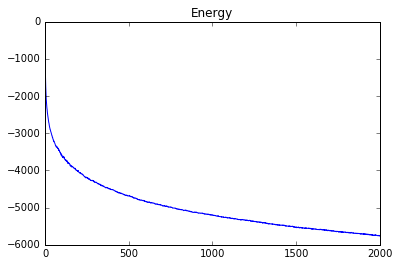

In [597]:
plt.plot(range(len(energies)), energies)
plt.title("Energy")

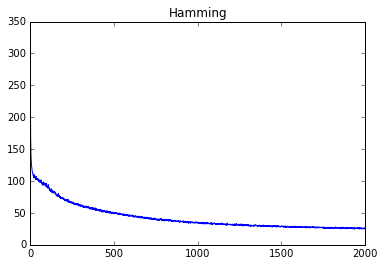

In [587]:
plt.plot(range(len(scores)), scores)
plt.title("Hamming")

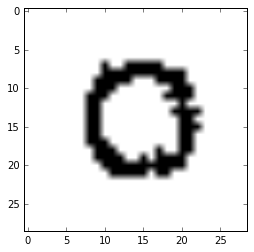

In [528]:
test_s = test_x[12]

plt.imshow(test_s.reshape((29,29)), cmap="gray")

In [529]:
import matplotlib.gridspec as gridspec

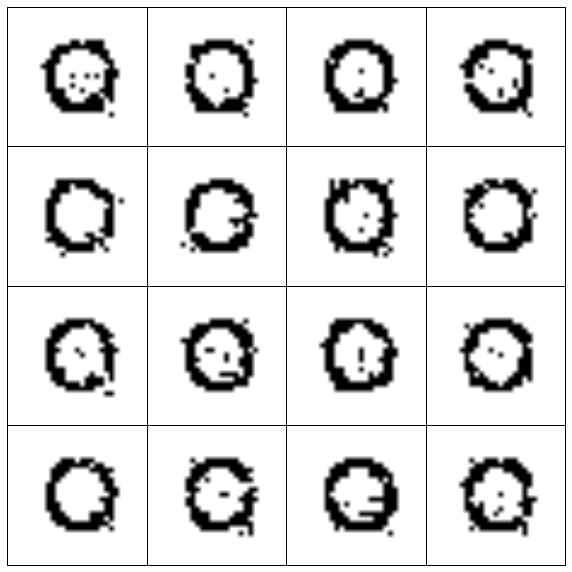

In [530]:

fig = plt.figure(figsize=(10, 10))

grid = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.0)
for i in range(16):
    ax = plt.Subplot(fig, grid[i])
    
    vis = sample(rbm.visible_step(rbm.hidden_step(test_s)))
    ax.imshow(vis.reshape((29,29)), cmap="gray")
    ax.set_xticks([]);ax.set_yticks([])
    fig.add_subplot(ax)

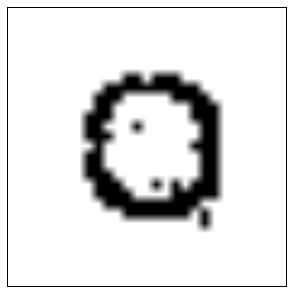

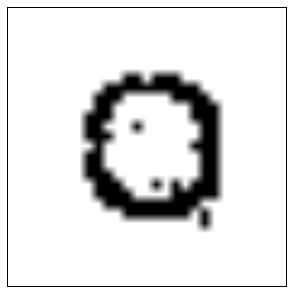

In [531]:
plt.figure(figsize=(5, 5))

for i in range(100):
    vis = sample(rbm.visible_step(rbm.hidden_step(test_s)))
    plt.imshow(vis.reshape((29,29)), cmap="gray")
    plt.xticks([]);plt.yticks([])

    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)